# Homework 1

This homework is intended as a brief overview of the machine learning process and the various topics you will learn in this class. We hope that this exercise will allow you to put in context the information you learn with us this semester. Don't worry if you don't understand the techniques here (that's what you'll learn this semester!); we just want to show you how you can use sklearn to do simple machine learning. 

## Setup

First let us import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

For this homework assignment, we will be using the MNIST dataset. The MNIST data is a collection of black and white 28x28 images, each picturing a handwritten digit. These were collected from digits people write at the post office, and now this dataset is a standard benchmark to evaluate models against used in the machine learning community. This may take some time to download. If this errors out, try rerunning it.

In [2]:
mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
y = mnist.target.astype('int64')

## Data Exploration

Let us first explore this data a little bit.

In [3]:
print(X.shape, y.shape) 

(70000, 784) (70000,)


The X matrix here contains all the digit pictures. The data is (n_samples x n_features), meaning this data contains 70,000 pictures, each with 784 features (the 28x28 image is flattened into a single row). The y vector contains the label for each digit, so we know which digit (or class - class means category) is in each picture.

Let's try and visualize this data a bit. Change around the index variable to explore more.

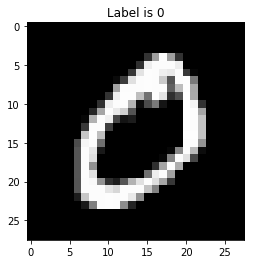

In [4]:
index = 0 #15000, 28999, 67345
image = X[index].reshape((28, 28))
plt.title('Label is ' + str(y[index]))
plt.imshow(image, cmap='gray')

Notice that each pixel value ranges from 0-255. When we train our models, a good practice is to *standardize* the data so different features can be compared more equally. Here we will use a simple standardization, squeezing all values into the 0-1 interval range.

In [5]:
X = X / 255

When we train our model, we want it to have the lowest error. Error presents itself in 2 ways: bias (how close our model is to the ideal model), and variance (how much our model varies with different datasets). If we train our model on a chunk of data, and then test our model on that same data, we will only witness the first type of error - bias. However, if we test on new, unseen data, that will reflect both bias and variance. This is the reasoning behind cross validation.

So, we want to have 2 datasets, train and test, each used for the named purpose exclusively.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Applying Models

Now we will walk you through applying various models to try and achieve the lowest error rate on this data.

Each of our labels is a number from 0-9. If we simply did regression on this data, the labels would imply some sort of ordering of the classes (ie the digit 8 is more of the digit 7 than the digit 3 is, etc. We can fix this issue by one-hot encoding our labels. So, instead of each label being a simple digit, each label is a vector of 10 entries. 9 of those entries are zero, and only 1 entry is equal to one, corresponding to the index of the digit. Let's take a look.

In [7]:
enc = OneHotEncoder(sparse=False)
y_hot = enc.fit_transform(y.reshape(-1, 1))
y_train_hot = enc.transform(y_train.reshape(-1, 1))
y_hot.shape

(70000, 10)

Remember how the first sample is the digit zero? Let's now look at the new label at that index.

In [8]:
y_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Linear Regression

There are 3 steps to build your model: create the model, train the model, then use your model to make predictions). In the sklearn API, this is made very clear. First you instantiate the model (constructor), then you call train it with the `fit` method, then you can make predictions on new data with the `test` method.

First, let's do a basic linear regression.

In [9]:
linear = LinearRegression()
linear.fit(X_train, y_train_hot)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# use trained model to predict both train and test sets
y_train_pred = linear.predict(X_train)
y_test_pred = linear.predict(X_test)

# print accuracies
print('train acc: ', accuracy_score(y_train_pred.argmax(axis=1), y_train))
print('test acc: ', accuracy_score(y_test_pred.argmax(axis=1), y_test))

train acc:  0.8589714285714286
test acc:  0.8516571428571429


Note on interpretability: you can view the weights of your model with `linear.coef_`

### Ridge Regression

Let us try and regularize by adding a penalty term to see if we can get anything better. We can penalize via the L2 norm, aka Ridge Regression.

In [11]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_hot)
print('train acc: ', accuracy_score(ridge.predict(X_train).argmax(axis=1), y_train))
print('test acc: ', accuracy_score(ridge.predict(X_test).argmax(axis=1), y_test))

train acc:  0.8589333333333333
test acc:  0.8518285714285714


The alpha controls how much to penalize the weights. Play around with it to see if you can improve the test accuracy.

Now you have seen how to use some basic models to fit and evaluate your data. You will now walk through working with more models. Fill in code where needed.

### Logistic Regression

We will now do logistic regression. From now on, the models will automatically one-hot the labels (so we don't need to worry about it).

In [12]:
logreg = LogisticRegression(C=0.01, multi_class='multinomial', solver='saga', tol=0.1)
logreg.fit(X_train, y_train)
print('train acc: ', accuracy_score(logreg.predict(X_train), y_train))
print('test acc: ', accuracy_score(logreg.predict(X_test), y_test))

train acc:  0.9179238095238095
test acc:  0.9178285714285714


Our accuracy has jumped ~5%! Why is this? Logistic Regression is a more complex model - instead of computing raw scores as in linear regression, it does one extra step and squashes values between 0 and 1. This means our model now optimizes over *probabilities* instead of raw scores. This makes sense since our vectors are 1-hot encoded.

The C hyperparameter controls inverse regularization strength (inverse for this model only). Reguralization is important to make sure our model doesn't overfit (perform much better on train data than test data). Play around with the C parameter to try and get better results! You should be able to hit 92%.

### Random Forest

Decision Trees are a completely different type of classifier. They essentially break up the possible space by repeatedly "splitting" on features to keep narrowing down the possibilities. Decision Trees are normally individually very week, so we typically average them together in bunches called Random Forest.

Now you have seen many examples for how to construct, fit, and evaluate a model. Now do the same for Random Forest using the [documentation here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). You should be able to create one easily without needing to specify any constructor parameters.

In [13]:
clf = RandomForestClassifier(max_depth = 50, random_state= 0,n_estimators= 100,min_samples_split= 4)
clf.fit(X_train, y_train)
print('test acc: ', accuracy_score(clf.predict(X_test), y_test))
print('train acc: ', accuracy_score(clf.predict(X_train), y_train))

test acc:  0.9698285714285714
train acc:  0.9998857142857143


WOWZA! That train accuracy is amazing, let's see if we can boost up the test accuracy a bit (since that's what really counts). Try and play around with the hyperparameters to see if you can edge out more accuracy (look at the documentation for parameters in the constructor). Focus on `n_estimators`, `min_samples_split`, `max_features`. You should be able to hit ~97%.

### SVC

A support vector classifier is another completely different type of classifier. It tries to find the best separating hyperplane through your data.

The SVC will toast our laptops unless we reduce the data dimensionality. Let's keep 80% of the variation, and get rid of the rest. (This will cause a slight drop in performance, but not by much).

In [14]:
pca = PCA(n_components=0.8, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Great! Now let's take a look at what that actually did.

In [15]:
X_train_pca.shape

(52500, 43)

Remember, before we had 784 (28x28) features! However, PCA found just 43 basis features that explain 80% of the data. So, we went to just 5% of the original input space, but we still retained 80% of the information! Nice.

This [blog post](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) explains dimensionality reduction with MNIST far better than I can. It's a short read (<10 mins), and it contains some pretty cool visualizations. Read it and jot down things you learned from the post or further questions.

In [18]:
lsvc = LinearSVC(dual=False, tol=0.01)
lsvc.fit(X_train_pca, y_train)
print('train acc: ', accuracy_score(lsvc.predict(X_train_pca), y_train))
print('test acc: ', accuracy_score(lsvc.predict(X_test_pca), y_test))

train acc:  0.8915238095238095
test acc:  0.8950857142857143


-It is hard to conceptualize higher dims.
-By looking at 2 pix. at a time help us gain a little intuition but not much.
-PCA => find the best horiz. + vert. angle
-Defined the cost of the distance of 2 points in the original space and the visualization.(Just wondering here, this is fundamental sorry, but why is it bad for distances not to be the same? Is it because our approximations in comparison to the original space aren't good enough?

Now let's train our first SVC. The LinearSVC can only find a linear decision boundary (the hyperplane).

SVMs are really interesting because they have something called the *dual formulation*, in which the computation is expressed as training point inner products. This means that data can be lifted into higher dimensions easily with this "kernel trick". Data that is not linearly separable in a lower dimension can be linearly separable in a higher dimension - which is why we conduct the transform. Let us experiment.

A transformation that lifts the data into a higher-dimensional space is called a kernel. A polynomial kernel expands the feature space by computing all the polynomial cross terms to a specific degree.

In [19]:
psvc = SVC(kernel='poly', degree=1, tol=0.01, cache_size=4000)
psvc.fit(X_train_pca, y_train)
print('train acc: ', accuracy_score(psvc.predict(X_train_pca), y_train))
print('test acc: ', accuracy_score(psvc.predict(X_test_pca), y_test))

train acc:  0.9303809523809524
test acc:  0.9277142857142857


Play around with the degree of the polynomial kernel to see what accuracy you can get.

The RBF kernel uses the gaussian function to create an infinite dimensional space - a gaussian peak at each datapoint. Now fiddle with the `C` and `gamma` parameters of the gaussian kernel below to see what you can get. [Here's documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [21]:
rsvc = SVC(kernel='rbf', tol=0.01, cache_size=4000,C = 1.0, gamma = 0.10000000000000001)
rsvc.fit(X_train_pca, y_train)
print('train acc: ', accuracy_score(rsvc.predict(X_train_pca), y_train))
print('test acc: ', accuracy_score(rsvc.predict(X_test_pca), y_test))

train acc:  0.9996190476190476
test acc:  0.9715428571428572


Isn't that just amazing accuracy?

## Basic Neural Network

You should never do neural networks in sklearn. Use Keras (which we will teach you later in this class), Tensorflow, PyTorch, etc. However, in an effort to keep this homework somewhat cohesive, let us proceed.

Basic neural networks proceed in layers. Each layer has a certain number of nodes, representing how expressive that layer can be. Below is a sample network, with an input layer, one hidden (middle) layer of 50 neurons, and finally the output layer.

In [22]:
nn = MLPClassifier(hidden_layer_sizes=(79,), solver='adam', verbose=1)
nn.fit(X_train_pca, y_train)
print('train acc: ', accuracy_score(nn.predict(X_train_pca), y_train))
print('test acc: ', accuracy_score(nn.predict(X_test_pca), y_test))

Iteration 1, loss = 1.01254076
Iteration 2, loss = 0.32751621
Iteration 3, loss = 0.23915568
Iteration 4, loss = 0.19751170
Iteration 5, loss = 0.17059502
Iteration 6, loss = 0.15126529
Iteration 7, loss = 0.13621792
Iteration 8, loss = 0.12447136
Iteration 9, loss = 0.11494617
Iteration 10, loss = 0.10679176
Iteration 11, loss = 0.09981043
Iteration 12, loss = 0.09381982
Iteration 13, loss = 0.08841084
Iteration 14, loss = 0.08364485
Iteration 15, loss = 0.07960517
Iteration 16, loss = 0.07604351
Iteration 17, loss = 0.07254231
Iteration 18, loss = 0.06956803
Iteration 19, loss = 0.06671120
Iteration 20, loss = 0.06417710
Iteration 21, loss = 0.06187784
Iteration 22, loss = 0.05974931
Iteration 23, loss = 0.05739583
Iteration 24, loss = 0.05585498
Iteration 25, loss = 0.05407596
Iteration 26, loss = 0.05234284
Iteration 27, loss = 0.05064165
Iteration 28, loss = 0.04918727
Iteration 29, loss = 0.04770698
Iteration 30, loss = 0.04664624
Iteration 31, loss = 0.04518638
Iteration 32, los

Fiddle around with the hiddle layers. Change the number of neurons, add more layers, experiment. You should be able to hit 98% accuracy.

Neural networks are optimized with a technique called gradient descent (a neural net is just one big function - so we can take the gradient with respect to all its parameters, then just go opposite the gradient to try and find the minimum). This is why it requires many iterations to converge.

## Turning In

Convert this notebook to a PDF (file -> download as -> pdf via latex) and submit to Gradescope.